### Packages

In [141]:
###Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

## Data Import

In [142]:
df = pd.read_csv("DataTrain-2.csv")

#### Check for null values and infinite values

In [143]:
# Checking which columns have any null values
columns_with_nulls = df.isnull().any()

# Filtering to show only columns with null values
columns_with_nulls_true = columns_with_nulls[columns_with_nulls].index.tolist()

print("Columns with null values:", columns_with_nulls_true)

# Check for columns with infinite values (positive or negative)
infinite_columns = df.isin([np.inf, -np.inf]).any()

# Filter and print column names that have infinite values
columns_with_infinity = infinite_columns[infinite_columns].index.tolist()
print("Columns with infinite values:", columns_with_infinity)

Columns with null values: []
Columns with infinite values: []


#### Create a new column RUL 

In [144]:
# Creating a new column with the max 'cycle' per 'engine_id'
df['max_cycle_per_engine'] = df.groupby('engine_id')['cycle'].transform('max')
# Creating the 'cycles_left' column
df['RUL'] = df['max_cycle_per_engine'] - df['cycle']
df.drop(['max_cycle_per_engine'], axis=1, inplace=True)

### Remove features with zero variance

In [145]:
# Calculating variance for each column
variances = df.var()

# Identifying columns with zero variance
zero_variance_columns = variances[variances == 0].index.tolist()

print("Columns with zero variance:", zero_variance_columns)

# Filtering out columns with zero variance
df = df.loc[:, variances > 0]

Columns with zero variance: ['set1', 'sensor_val7', 'sensor_val11', 'sensor_val14', 'sensor_val16']


#### Remove the columns with one unique value

In [146]:
# Checking the number of unique values per column
unique_counts = df.nunique()

# Identifying columns with only one unique value
columns_to_remove = unique_counts[unique_counts == 1].index.tolist()

# Removing these columns from the DataFrame
df.drop(columns=columns_to_remove, inplace=True)

# Printing the names of the columns that were removed
print("Columns removed:", columns_to_remove)

Columns removed: ['sensor_val8', 'sensor_val20']


## Correlation matrix

              engine_id     cycle      set2      set3  sensor_val1  \
engine_id      1.000000  0.078753 -0.017895 -0.006197    -0.052053   
cycle          0.078753  1.000000 -0.004527  0.016132     0.443999   
set2          -0.017895 -0.004527  1.000000  0.011660    -0.004279   
set3          -0.006197  0.016132  0.011660  1.000000    -0.005425   
sensor_val1   -0.052053  0.443999 -0.004279 -0.005425     1.000000   
sensor_val2   -0.031882 -0.611354 -0.001491 -0.010923    -0.210238   
sensor_val3   -0.059473  0.370324 -0.004469 -0.006310     0.963157   
sensor_val4    0.012621  0.543947 -0.005651  0.009068     0.322964   
sensor_val5   -0.032073 -0.595914 -0.009437 -0.016678    -0.217835   
sensor_val6   -0.020589 -0.583597 -0.005713 -0.010554    -0.285280   
sensor_val9    0.044230  0.477523  0.002318  0.018156    -0.034763   
sensor_val10   0.026116  0.624577  0.009544  0.014673     0.297429   
sensor_val12   0.013513  0.566995  0.002599  0.012280     0.337110   
sensor_val13   0.039

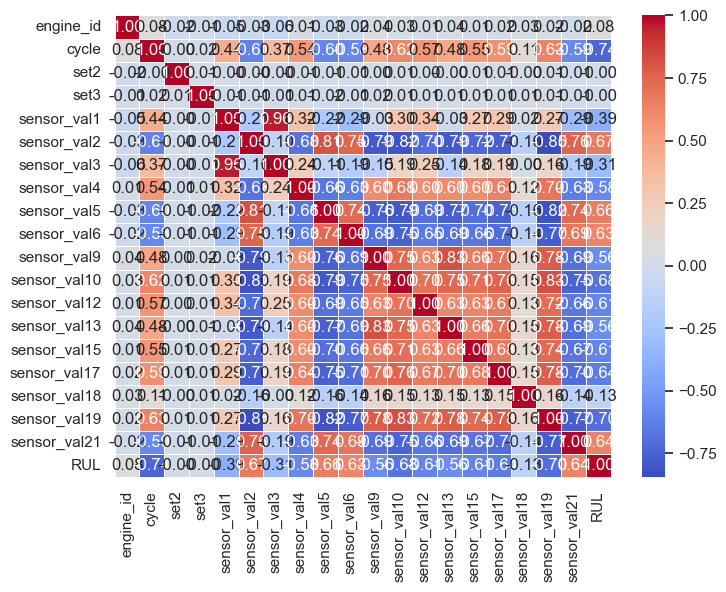

In [147]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualizing the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [148]:
rul_correlations = correlation_matrix['RUL']

# Display the correlations of 'RUL' with other features
print(rul_correlations)

engine_id       0.078753
cycle          -0.736241
set2           -0.003198
set3           -0.001948
sensor_val1    -0.390102
sensor_val2     0.671983
sensor_val3    -0.306769
sensor_val4    -0.584520
sensor_val5     0.657223
sensor_val6     0.629428
sensor_val9    -0.562569
sensor_val10   -0.678948
sensor_val12   -0.606154
sensor_val13   -0.563968
sensor_val15   -0.606484
sensor_val17   -0.642667
sensor_val18   -0.128348
sensor_val19   -0.696228
sensor_val21    0.635662
RUL             1.000000
Name: RUL, dtype: float64


In [149]:
df.columns

Index(['engine_id', 'cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21', 'RUL'],
      dtype='object')

## Add lag features

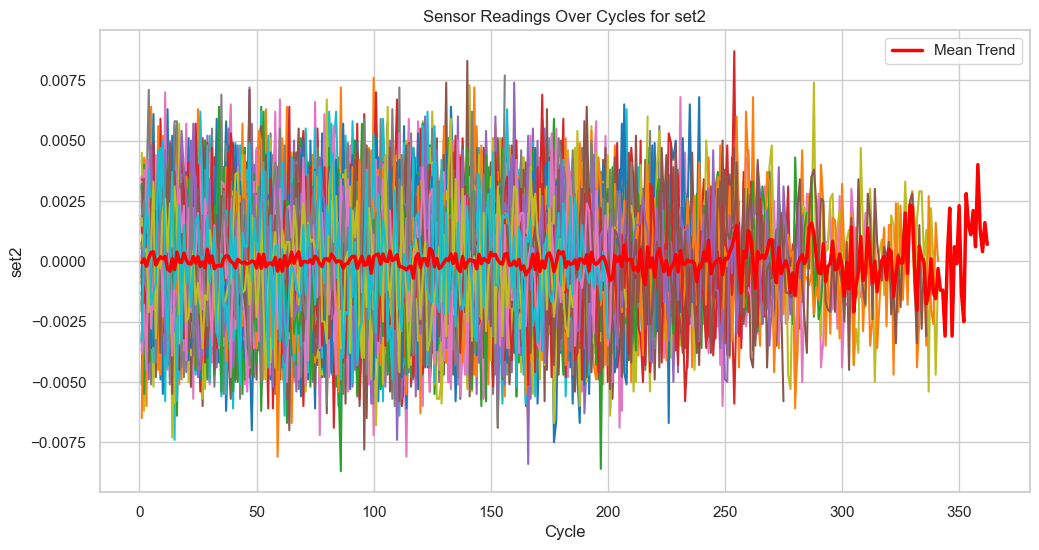

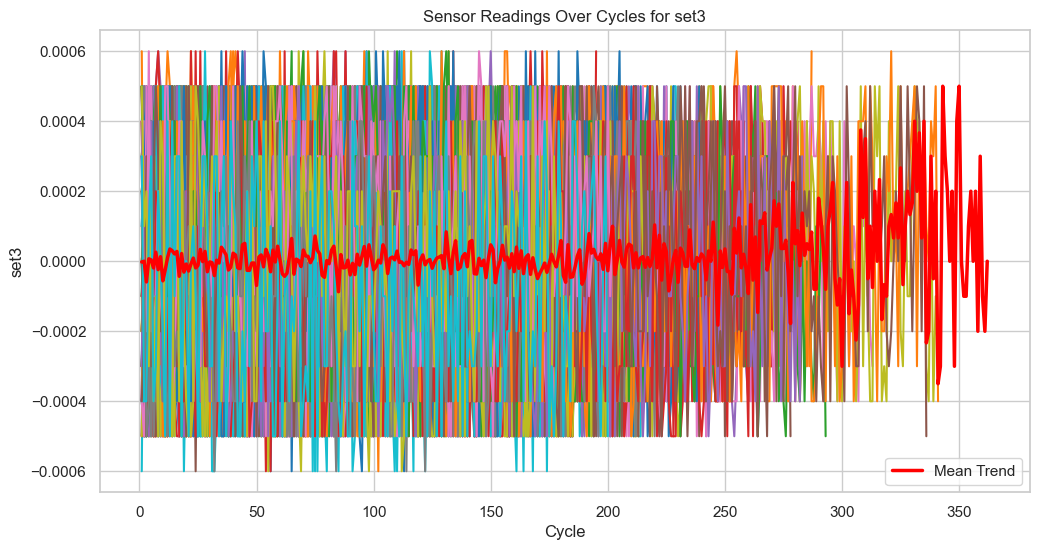

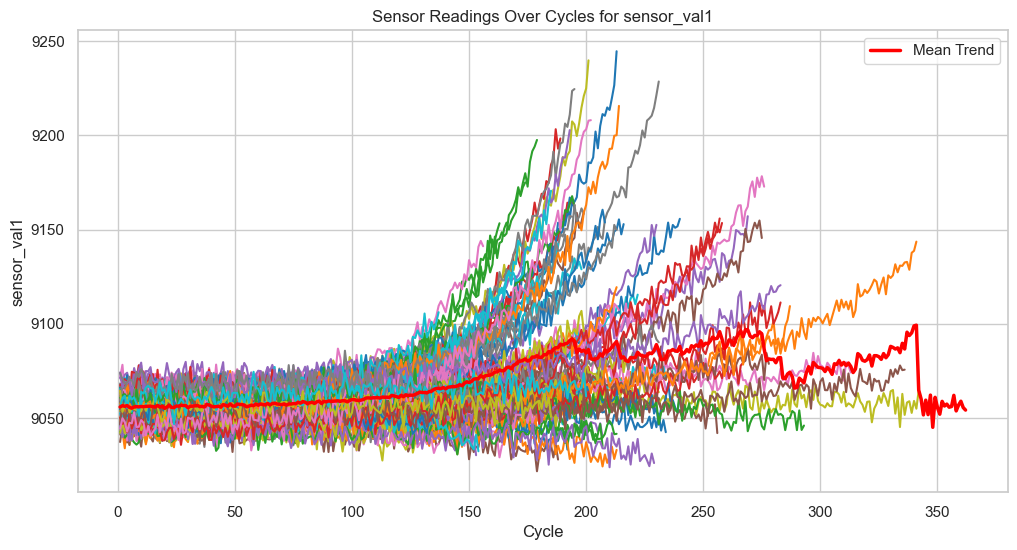

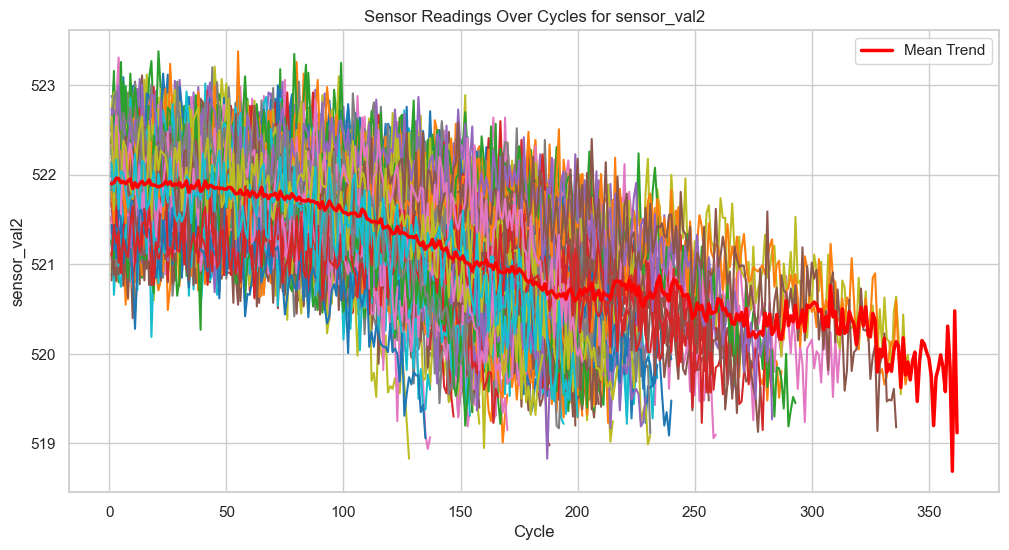

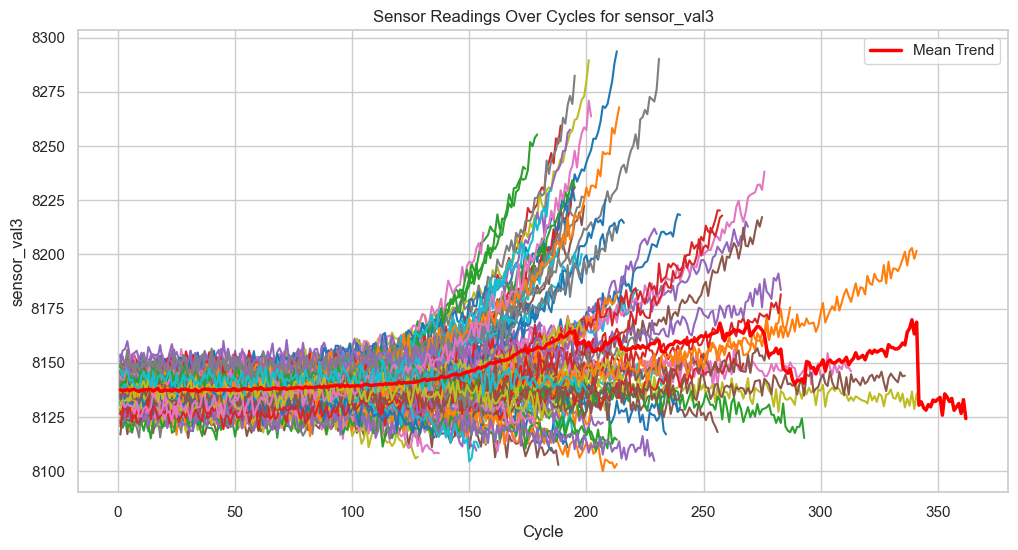

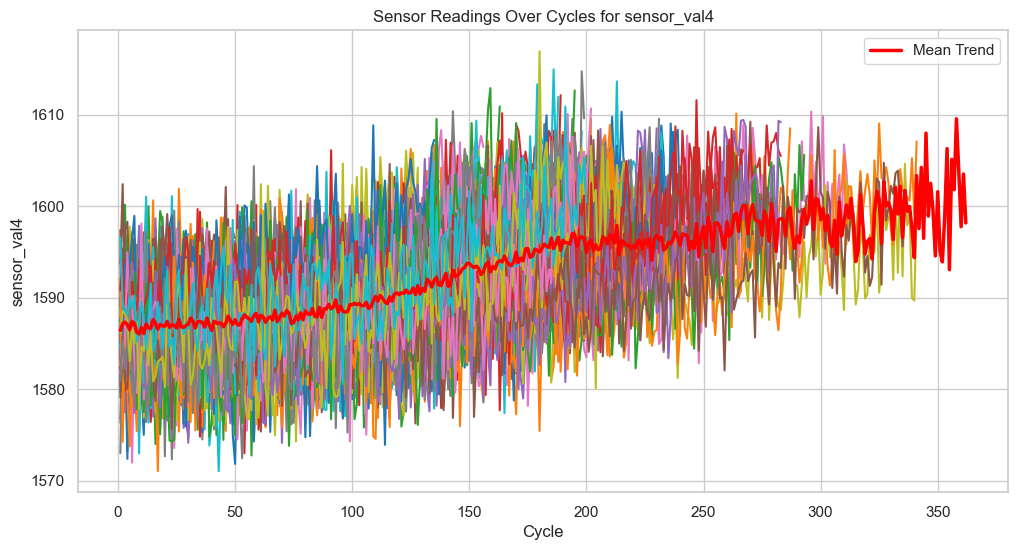

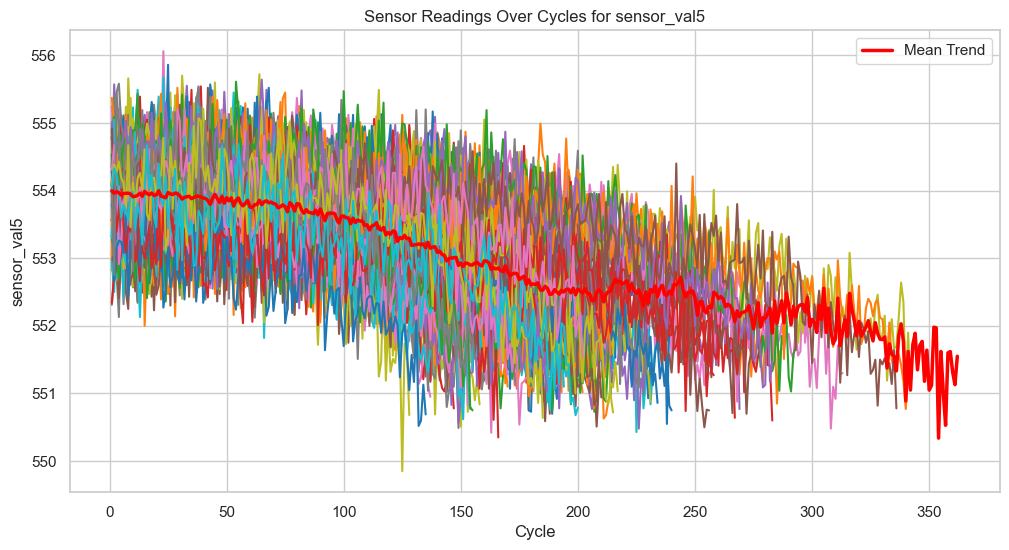

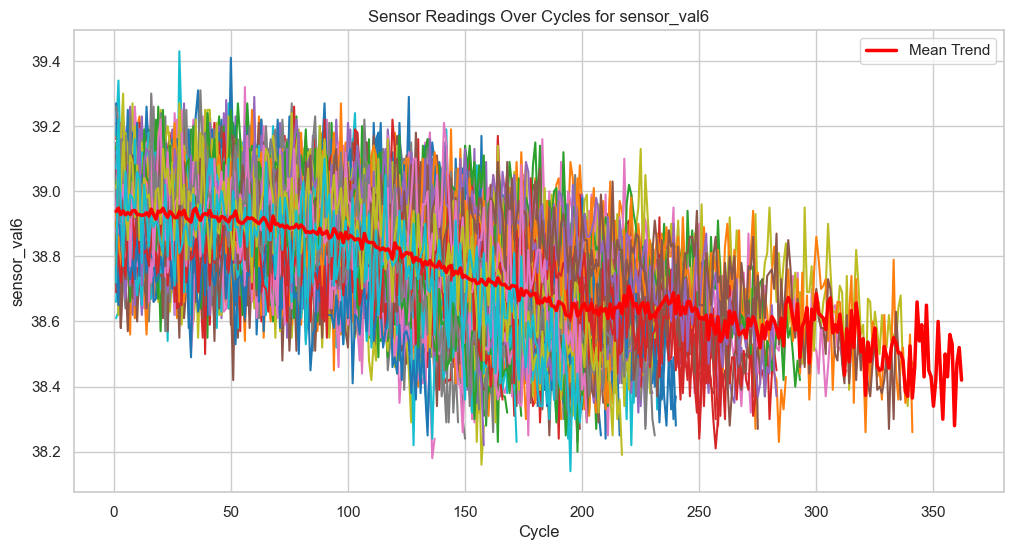

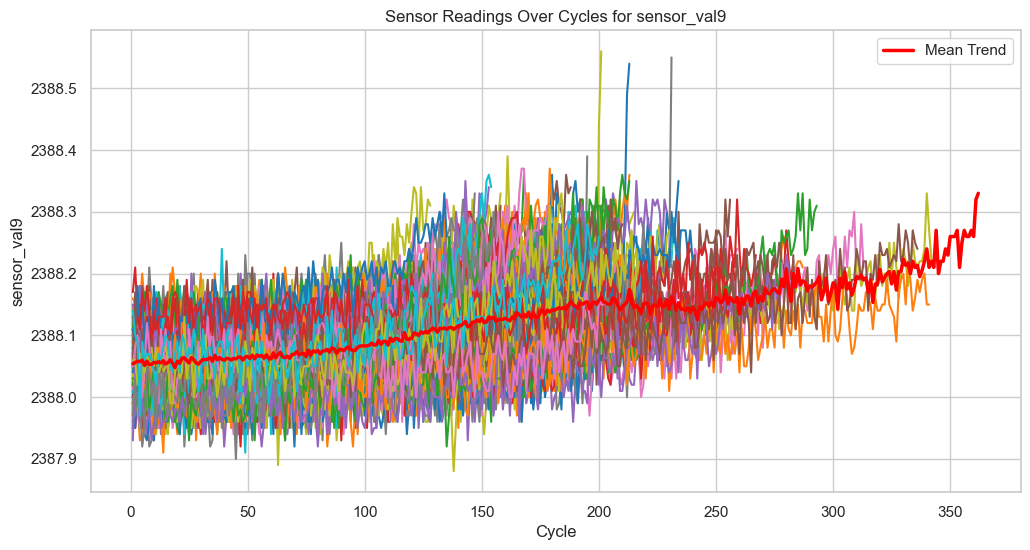

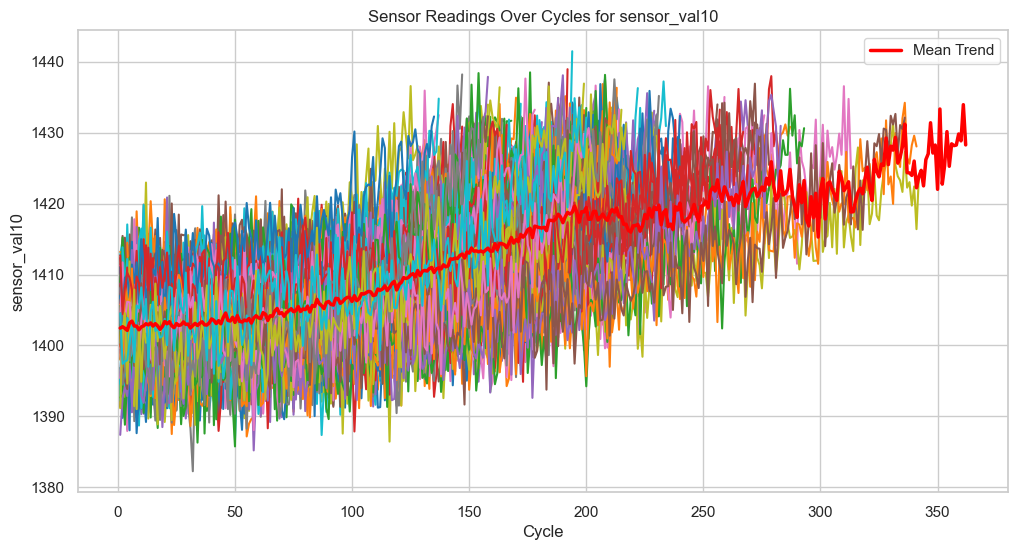

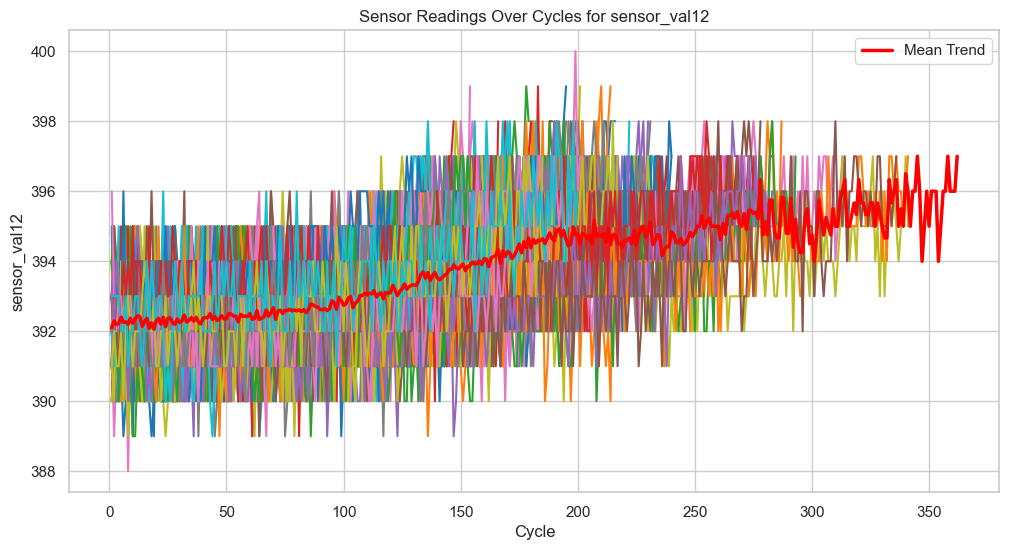

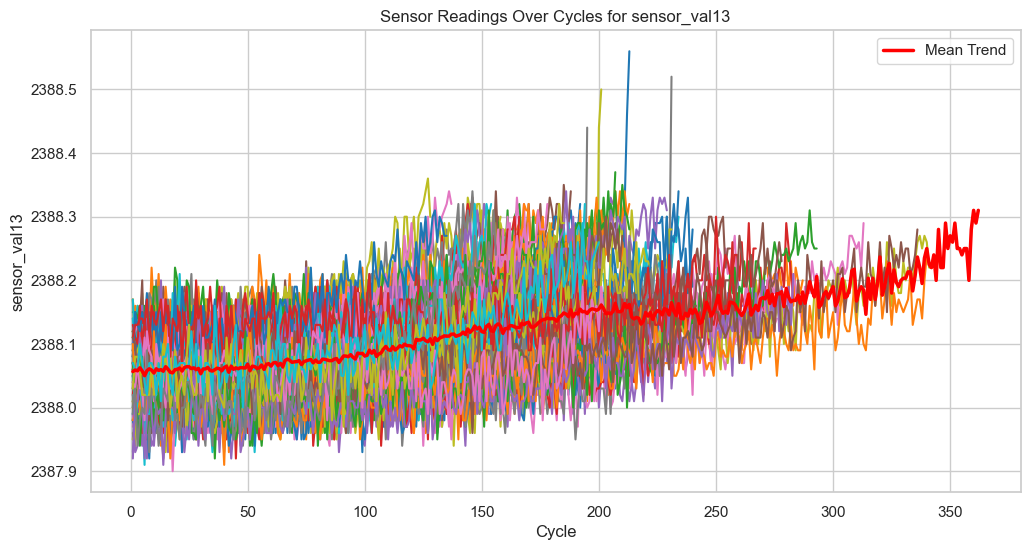

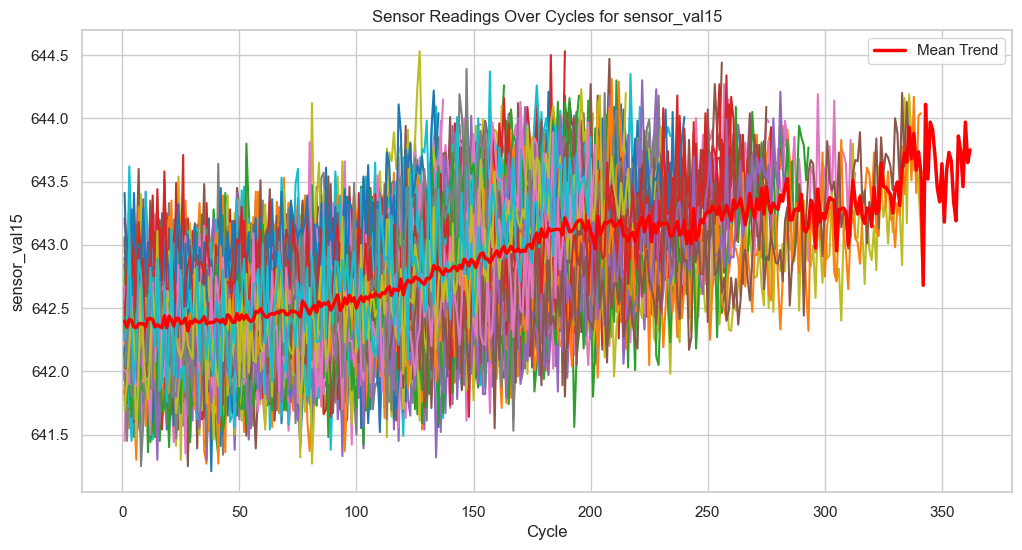

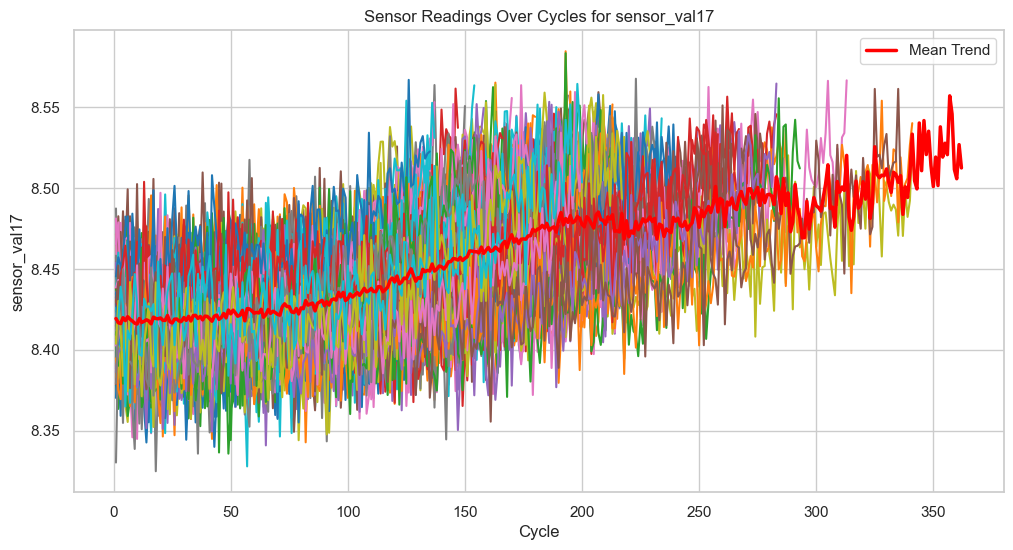

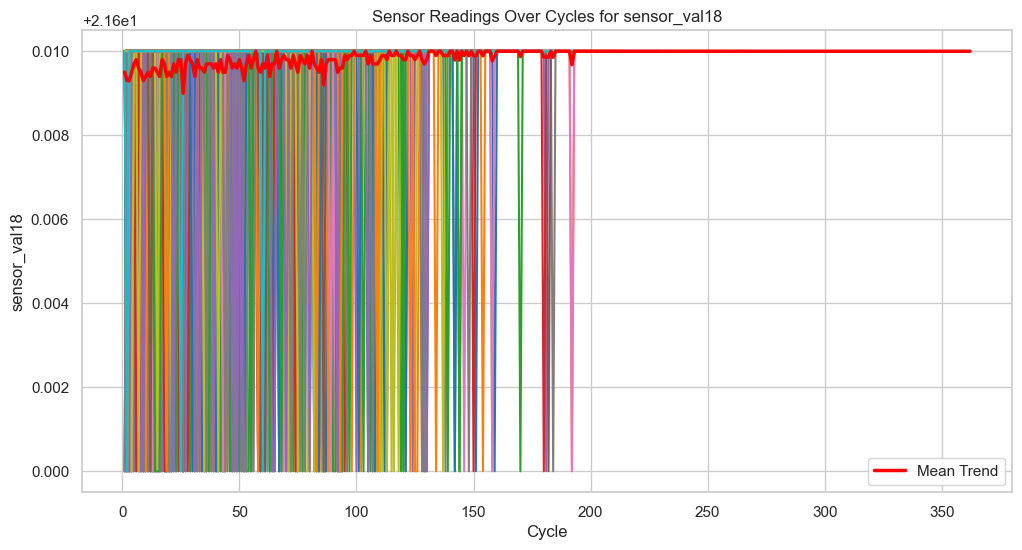

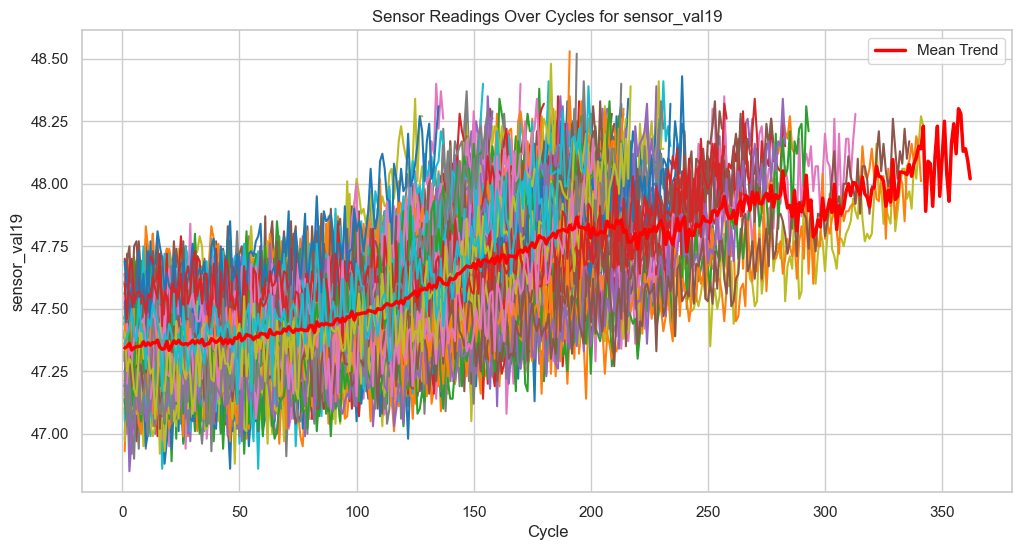

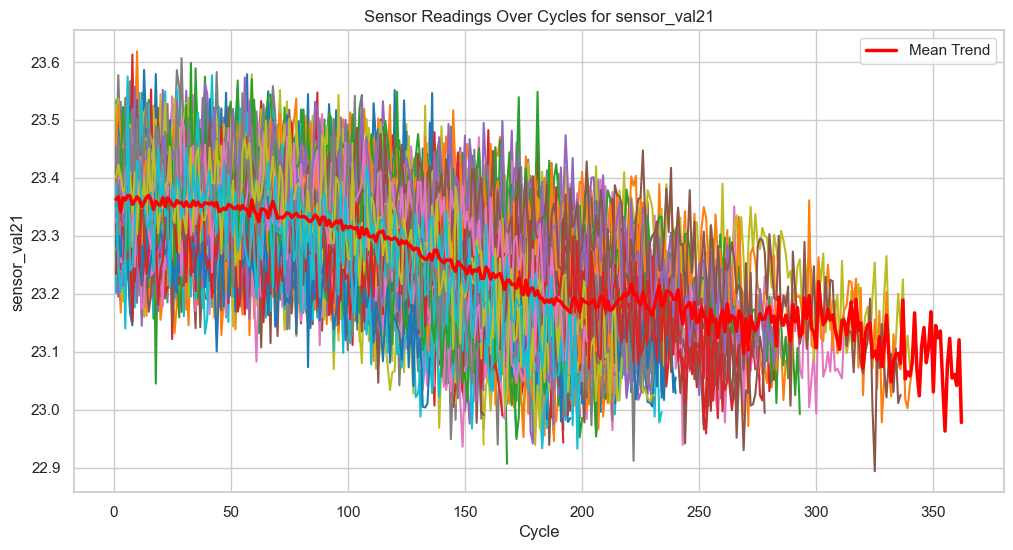

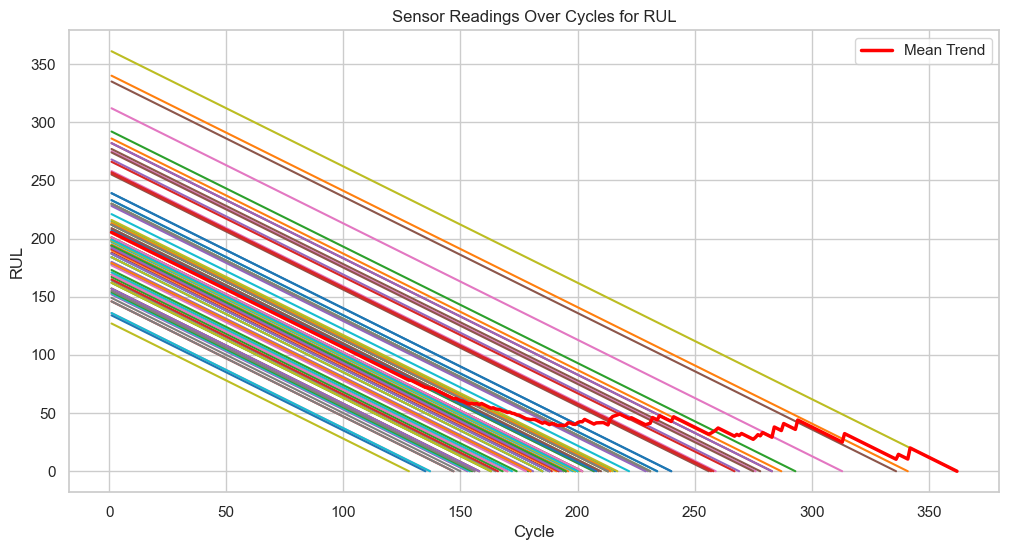

In [122]:
# Calculate mean values across all engines for each cycle
mean_df = df.groupby('cycle').mean().reset_index()
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_sensors(df, mean_df):
    sns.set(style="whitegrid")  # Set the aesthetic style of the plots

    # Define columns that are not to be included in plotting (non-sensor columns)
    exclude_columns = ['engine_id', 'cycle']
    sensor_columns = [col for col in df.columns if col not in exclude_columns]

    for sensor in sensor_columns:
        plt.figure(figsize=(12, 6))  # Adjust the size of the figure for better visibility

        # Plotting each engine's sensor data (you can remove this part if you want only the mean trendline)
        sns.lineplot(data=df, x='cycle', y=sensor, hue='engine_id', palette='tab10', legend=None)
        
        # Plotting the mean trendline
        sns.lineplot(data=mean_df, x='cycle', y=sensor, color='red', linewidth=2.5, label='Mean Trend')

        plt.title(f'Sensor Readings Over Cycles for {sensor}')
        plt.xlabel('Cycle')
        plt.ylabel(sensor)
        # plt.legend(title='Engine ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Removed as per requirement
        plt.show()

# Assuming your DataFrame is ready and named 'df'
plot_mean_sensors(df, mean_df)

In [150]:
# define a function to create difference features that capture the rate of change in sensor readings compared to the first cycle

def create_difference_features(df, sensor_columns):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_diff = df.copy()

    # Create difference features for each sensor column
    for sensor in sensor_columns:
        # Create a new column name for the difference feature
        diff_col = f'{sensor}_diff'

        # Calculate the difference values
        df_diff[diff_col] = df_diff.groupby('engine_id')[sensor].transform(lambda group: group - group.iloc[0])

    return df_diff

# Define the sensor columns to create difference features for
sensor_columns = ['sensor_val2', 'sensor_val4', 'sensor_val5', 'sensor_val6',
                  'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13', 'sensor_val15', 'sensor_val17', 'sensor_val19', 'sensor_val21']

# Create difference features for the selected sensor columns
df_diff = create_difference_features(df, sensor_columns)

# Only keep difference features and the 'engine_id' and 'cycle' columns
df_diff_clean = df_diff[['engine_id', 'cycle'] + [col for col in df_diff.columns if 'diff' in col]]

# Left join the difference features with the original DataFrame on 'engine_id' and 'cycle'
df = df.merge(df_diff_clean, on=['engine_id', 'cycle'], how='left')

# Display the resulting DataFrame
print(df.head())

   engine_id  cycle    set2    set3  sensor_val1  sensor_val2  sensor_val3  \
0          1      1 -0.0007 -0.0004      9046.19       521.66      8138.62   
1          1      2  0.0019 -0.0003      9044.07       522.28      8131.49   
2          1      3 -0.0043  0.0003      9052.94       522.42      8133.23   
3          1      4  0.0007  0.0000      9049.48       522.86      8133.83   
4          1      5 -0.0019 -0.0002      9055.15       522.19      8133.80   

   sensor_val4  sensor_val5  sensor_val6  ...  sensor_val5_diff  \
0      1589.70       554.36        39.06  ...              0.00   
1      1591.82       553.75        39.00  ...             -0.61   
2      1587.99       554.26        38.95  ...             -0.10   
3      1582.79       554.45        38.88  ...              0.09   
4      1582.85       554.00        38.90  ...             -0.36   

   sensor_val6_diff  sensor_val9_diff  sensor_val10_diff  sensor_val12_diff  \
0              0.00              0.00            

In [124]:
df.head(100)

engine_id  cycle    set2    set3  sensor_val1  sensor_val2  sensor_val3  \
0           1      1 -0.0007 -0.0004      9046.19       521.66      8138.62   
1           1      2  0.0019 -0.0003      9044.07       522.28      8131.49   
2           1      3 -0.0043  0.0003      9052.94       522.42      8133.23   
3           1      4  0.0007  0.0000      9049.48       522.86      8133.83   
4           1      5 -0.0019 -0.0002      9055.15       522.19      8133.80   
..        ...    ...     ...     ...          ...          ...          ...   
95          1     96 -0.0034  0.0001      9048.71       521.66      8130.69   
96          1     97  0.0035 -0.0003      9046.10       521.67      8128.74   
97          1     98  0.0006  0.0004      9045.49       522.31      8127.89   
98          1     99 -0.0005 -0.0000      9045.14       521.42      8131.77   
99          1    100 -0.0021 -0.0003      9045.72       521.55      8132.49   

    sensor_val4  sensor_val5  sensor_val6  ...  sensor_val5_diff  \
0       1589.70       554.36        39.06  ...              0.00   
1       1591.82       553.75        39.00  ...             -0.61   
2       1587.99       554.26        38.95  ...             -0.10   
3       1582.79       554.45        38.88  ...              0.09   
4       1582.85       554.00        38.90  ...             -0.36   
..          ...          ...          ...  ...               ...   
95      1584.07       553.34        38.88  ...             -1.02   
96      1595.77       553.40        39.01  ...             -0.96   
97      1591.11       552.75        38.96  ...             -1.61   
98      1592.73       553.76        38.82  ...             -0.60   
99      1589.63       554.22        38.93  ...             -0.14   

    sensor_val6_diff  sensor_val9_diff  sensor_val10_diff  sensor_val12_diff  \
0               0.00              0.00               0.00                  0   
1              -0.06              0.05               2.54                  0   
2              -0.11              0.01               3.60                 -2   
3              -0.18              0.06               1.27                  0   
4              -0.16              0.02               5.62                  1   
..               ...               ...                ...                ...   
95             -0.18              0.04              -5.44                  0   
96             -0.05              0.04               7.21                  0   
97             -0.10              0.04               3.96                 -1   
98             -0.24              0.08               5.53                  1   
99             -0.13              0.06              10.75                  0   

    sensor_val13_diff  sensor_val15_diff  sensor_val17_diff  \
0                0.00               0.00             0.0000   
1               -0.02               0.33             0.0123   
2                0.02               0.53            -0.0017   
3                0.05               0.53            -0.0513   
4                0.00               0.55             0.0099   
..                ...                ...                ...   
95               0.01               0.37             0.0116   
96               0.03               0.25            -0.0090   
97               0.00               0.18            -0.0183   
98               0.02               0.64             0.0286   
99               0.01               0.40             0.0046   

    sensor_val19_diff  sensor_val21_diff  
0                0.00             0.0000  
1                0.02             0.0046  
2               -0.20            -0.0748  
3               -0.34            -0.0451  
4               -0.19            -0.0146  
..                ...                ...  
95              -0.08            -0.0935  
96              -0.01            -0.1227  
97              -0.10            -0.1636  
98              -0.07            -0.1867  
99               0.17            -0.0100  

[10

## Modeling linear regression

In [125]:
# Defining the dependent variable and independent variables
X = df[['cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21', 'sensor_val2_diff', 'sensor_val4_diff', 'sensor_val5_diff', 'sensor_val6_diff', 'sensor_val9_diff', 'sensor_val10_diff', 'sensor_val12_diff', 'sensor_val13_diff', 'sensor_val15_diff', 'sensor_val17_diff', 'sensor_val19_diff', 'sensor_val21_diff']]    # possible to add lag RUL
y = df['RUL']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Setting up the OLS model
model = sm.OLS(y, X)

# Fitting the model
results = model.fit()

# Printing the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1574.
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        23:02:00   Log-Likelihood:            -1.0430e+05
No. Observations:               20631   AIC:                         2.087e+05
Df Residuals:                   20600   BIC:                         2.089e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.831e+05   3.32e+0

eventhough set 2 had a higher correlation with RUL than set 3, controlling for other variables revealed that set 2 is not significant

remove set 2 as a feature, and drop other non-significant features

In [136]:
# Defining the dependent variable and independent variables
X = df[['cycle', 'set3', 'sensor_val1', 'sensor_val2', 'sensor_val4', 'sensor_val5', 'sensor_val6', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val1',
       'sensor_val21', 'sensor_val2_diff', 'sensor_val5_diff', 'sensor_val6_diff', 'sensor_val9_diff', 'sensor_val13_diff', 'sensor_val15_diff', 'sensor_val17_diff', 'sensor_val19_diff', 'sensor_val21_diff']] 

In [137]:
# Define the dependent variable and independent variables
y = df['RUL']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Applying 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))

# Output the results of cross-validation
print("CV Scores:", cv_scores)
print("CV Average Score:", np.mean(cv_scores))

CV Scores: [20.33325962 20.71310512 20.45781581 20.62162375 20.38090909]
CV Average Score: 20.50134267852717


In [138]:
# Random Forest model setup
rf = RandomForestRegressor(random_state=42)

# Define parameter space for Bayesian Optimization
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

# Setting up Bayesian Search
opt = BayesSearchCV(estimator=rf, search_spaces=search_spaces, n_iter=32, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2, random_state=42)

# Fitting Bayesian Search
opt.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", opt.best_params_)
print("Best score (neg_mean_absolute_error):", opt.best_score_)

# Optionally, check the performance on the test set
best_rf = opt.best_estimator_
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [139]:
# Specify the file path to save the model
model_file_path = 'best_random_forest_model.pkl'

# Save the model to disk
with open(model_file_path, 'wb') as file:
    pickle.dump(best_rf, file)

print(f"Model saved to {model_file_path}")

Model saved to best_random_forest_model.pkl


In [158]:
df = pd.read_csv("DataSchedule-2.csv")

# Create difference features for the selected sensor columns
df_diff = create_difference_features(df, sensor_columns)

# Only keep difference features and the 'engine_id' and 'cycle' columns
df_diff_clean = df_diff[['engine_id', 'cycle'] + [col for col in df_diff.columns if 'diff' in col]]

# Left join the difference features with the original DataFrame on 'engine_id' and 'cycle'
df = df.merge(df_diff_clean, on=['engine_id', 'cycle'], how='left')

# Specify the path to the pickled model file
model_file_path = 'best_random_forest_model.pkl'
# Load the model from disk
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)
df_features = df[['cycle', 'set3', 'sensor_val1', 'sensor_val2', 'sensor_val4', 'sensor_val5', 'sensor_val6', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val1',
       'sensor_val21', 'sensor_val2_diff', 'sensor_val5_diff', 'sensor_val6_diff', 'sensor_val9_diff', 'sensor_val13_diff', 'sensor_val15_diff', 'sensor_val17_diff', 'sensor_val19_diff', 'sensor_val21_diff']] 

In [159]:
#Making predictions and round to the nearest integer
predictions = np.round(model.predict(df_features))

#Converting to integer type
predictions = predictions.astype(int)
predictions

## add the predictions to df
df['RUL'] = predictions
df
## Take the final row of each engine id
# Group by 'engine_id' and get the last 'RUL' value for each engine
last_rul_per_engine = df.groupby('engine_id')['RUL'].last()
last_rul_per_engine_df = last_rul_per_engine.reset_index()
# Combine 'RUL' and 'engine_id' into a single column formatted as "RUL;id"
last_rul_per_engine_df['RUL;id'] = last_rul_per_engine_df['RUL'].astype(str) + ';' + last_rul_per_engine_df[
    'engine_id'].astype(str)

In [160]:
# Create a new DataFrame with only the combined column
result_df = last_rul_per_engine_df[['RUL;id']]

# Save the DataFrame to a CSV file
result_df.to_csv('rul_id_pairs.csv', index=False, header=True)

In [161]:
# Compare to the consultancy predictions
df_our_predictions = pd.read_csv('rul_id_pairs.csv')
df_our_predictions["RULours;engine_id"] = df_our_predictions["RUL;id"]
df_our_predictions.drop(['RUL;id'], axis=1, inplace=True)
df_consultancy = pd.read_csv("RUL_consultancy_predictions_A3-2.csv")
df_consultancy["RULconsul;engine_id"] = df_consultancy["RUL;id"]
df_consultancy.drop(['RUL;id'], axis=1, inplace=True)
df_combined = pd.concat([df_our_predictions, df_consultancy], axis=1)
df_combined
# Split the 'RUL;id' column into two new columns
df_combined[['RULours', 'engine_id']] = df_combined['RULours;engine_id'].str.split(';', expand=True)
df_combined[['RULconsul', 'old_id']] = df_combined['RULconsul;engine_id'].str.split(';', expand=True)

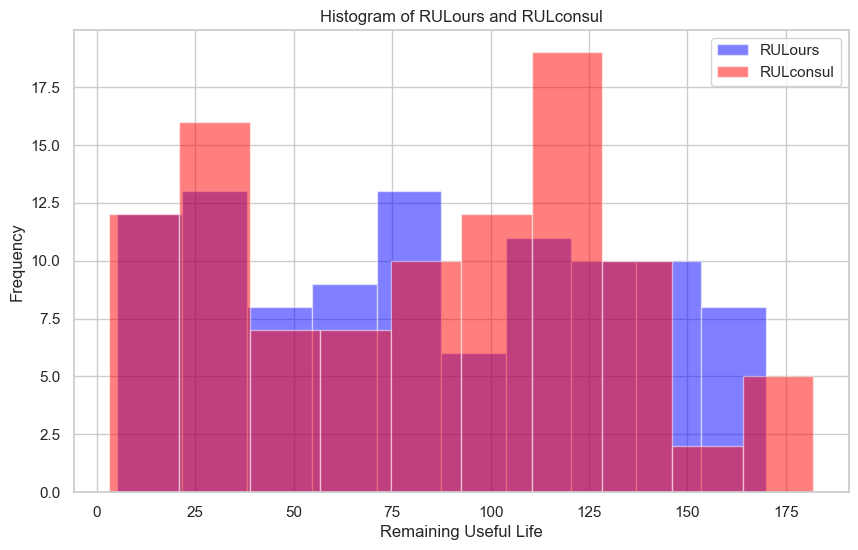

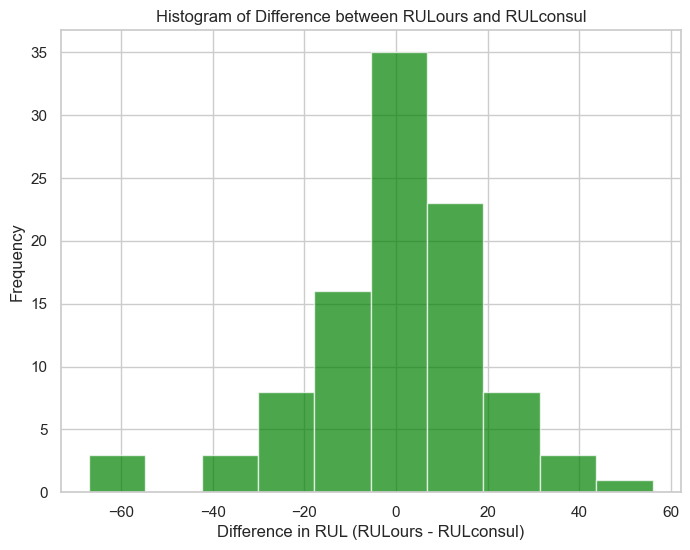

In [162]:
# Drop the original columns
df_combined.drop(['RULours;engine_id', 'RULconsul;engine_id'], axis=1, inplace=True)

# drop the old_id
df_combined.drop(['old_id'], axis=1, inplace=True)

#Convert these columns to an appropriate type (e.g., int)
df_combined['RULours'] = df_combined['RULours'].astype(float)
df_combined['RULconsul'] = df_combined['RULconsul'].astype(float)
df_combined['engine_id'] = df_combined['engine_id'].astype(int)
df_combined
# Plotting histograms
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Histogram for RULours
plt.hist(df_combined['RULours'], bins=10, alpha=0.5, label='RULours', color='blue')

# Histogram for RULconsul
plt.hist(df_combined['RULconsul'], bins=10, alpha=0.5, label='RULconsul', color='red')

# Adding labels and title
plt.xlabel('Remaining Useful Life')
plt.ylabel('Frequency')
plt.title('Histogram of RULours and RULconsul')
plt.legend(loc='upper right')

# Show plot
plt.show()
# Calculate the difference between RULours and RULconsul
df_combined['Difference'] = df_combined['RULours'] - df_combined['RULconsul']

# Plotting the histogram of the differences
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
plt.hist(df_combined['Difference'], bins=10, color='green', alpha=0.7)
plt.xlabel('Difference in RUL (RULours - RULconsul)')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between RULours and RULconsul')
plt.grid(True)  # Optional: adds a grid for easier readability
plt.show()

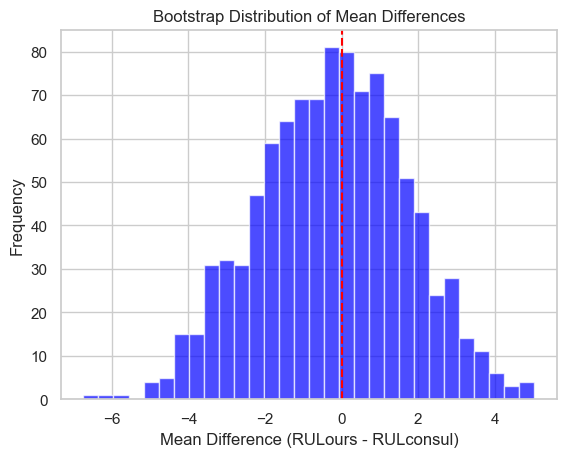

95% Confidence Interval for the Mean Difference: [-4.01025  3.46   ]


In [163]:
def bootstrap_diff(data, n_bootstrap=1000):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        # Sample with replacement from the data
        sample = data.sample(n=len(data), replace=True)
        # Calculate the mean difference
        mean_diff = sample['RULours'].mean() - sample['RULconsul'].mean()
        bootstrap_means.append(mean_diff)
    return bootstrap_means


# Performing bootstrap sampling
diffs = bootstrap_diff(df_combined)

# Plotting the distribution of bootstrap differences
plt.hist(diffs, bins=30, color='blue', alpha=0.7)
plt.xlabel('Mean Difference (RULours - RULconsul)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Mean Differences')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()
# Calculating the 95% confidence interval
conf_interval = np.percentile(diffs, [2.5, 97.5])
print("95% Confidence Interval for the Mean Difference:", conf_interval)